# Big Data

## Conjunto de datos: [Data Science Salaries Dataset](https://www.kaggle.com/datasets/yusufdelikkaya/datascience-salaries-2024/data)

**Procesamiento en batch:**

* Cargar el conjunto de datos seleccionados desde la fuente original.
* Realizar operaciones de limpieza, transformación y análisis exploratorio de datos (EDA) utilizando RDDs o DataFrames.
* Almacenar los resultados procesados.

## Importar las librerías necesarias

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count, desc, when, udf, isnull, avg, stddev
from pyspark.sql.types import *

## Creación de sesión de Apache Spark optimizada

In [ ]:
# Crear sesión Spark con configuración optimizada
spark = SparkSession.builder \
    .appName("DataScienceSalaries") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Mostrar versión de Spark
print("Spark version:", spark.version)

Spark version: 3.5.5


## Cargar de datos desde CSV

In [ ]:
# Definir esquema manual para validación

schema = StructType([
    StructField("work_year", IntegerType()),
    StructField("experience_level", StringType()),
    StructField("employment_type", StringType()),
    StructField("job_title", StringType()),
    StructField("salary", IntegerType()),
    StructField("salary_currency", StringType()),
    StructField("salary_in_usd", IntegerType()),
    StructField("employee_residence", StringType()),
    StructField("remote_ratio", IntegerType()),
    StructField("company_location", StringType()),
    StructField("company_size", StringType())
])

# Cargar CSV con esquema definido
try:
    df = spark.read \
    .schema(schema) \
    .option("header", True) \
    .option("inferSchema", False) \
    .csv("/data/DataScience_salaries_2024.csv")
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    # Detener la ejecución si no se pueden cargar los datos
    spark.stop()
    exit()

Datos cargados exitosamente.


## Mostrar Número de registros

In [ ]:
# Mostrar Número de registros
print("Número de registros:", df.count())

Número de registros: 14838


## Imprimir el esquema del DataFrame para entender la estructura de los datos



In [ ]:
# Imprimir el esquema del DataFrame para entender la estructura de los datos
print("Esquema del DataFrame:")
df.printSchema()

Esquema del DataFrame:
root
 |-- work_year: integer (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: integer (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



# Mostrar las primeras filas del DataFrame

In [ ]:
## Mostrar las primeras filas del DataFrame
print("Primeras 15 filas del DataFrame:")
df.show(15)

Primeras 15 filas del DataFrame:
+---------+----------------+---------------+--------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|  salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|     2021|              MI|             FT|      Data Scientist|30400000|            CLP|        40038|                CL|         100|              CL|           L|
|     2021|              MI|             FT|     BI Data Analyst|11000000|            HUF|        36259|                HU|          50|              US|           L|
|     2020|              MI|             FT|      Data Scientist|11000000|            HUF|        35735|                HU|         

## Contar el número total de filas

In [ ]:
# Contar el número total de filas
total_filas = df.count()
print(f"Número total de filas: {total_filas}")

Número total de filas: 14838


## Obtener estadísticas descriptivas de las columnas numéricas

In [ ]:
# Obtener estadísticas descriptivas de las columnas numéricas
# print("Estadísticas descriptivas de las columnas numéricas:")
# df.describe().show()

# Estadísticas descriptivas para columnas numéricas
numeric_cols = [field.name for field in df.schema.fields if field.dataType.typeName() in ("integer", "double", "float")]
df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         work_year|            salary|     salary_in_usd|     remote_ratio|
+-------+------------------+------------------+------------------+-----------------+
|  count|             14838|             14838|             14838|            14838|
|   mean|2023.1389001213101|165022.71896482006|149874.71876263648|32.76047984903626|
| stddev|0.7007985532604277| 356235.4265223536| 69009.18134882109|46.48827796585933|
|    min|              2020|             14000|             15000|                0|
|    max|              2024|          30400000|            800000|              100|
+-------+------------------+------------------+------------------+-----------------+



# Estadísticas descriptivas para columna específica

In [ ]:
# Estadísticas descriptivas para una columna específica
df.select("work_year").describe().show()

+-------+------------------+
|summary|         work_year|
+-------+------------------+
|  count|             14838|
|   mean|2023.1389001213101|
| stddev|0.7007985532604277|
|    min|              2020|
|    max|              2024|
+-------+------------------+



# Limpieza de datos

## Valores Nulos

In [ ]:
# Valores nulos por columna
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|        0|               0|              0|        0|     0|              0|            0|                 0|           0|               0|           0|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+



In [ ]:
# Filas con valores nulos
df.filter(df.remote_ratio.isNull() | df.salary_in_usd.isNull() | df.salary.isNull() | df.work_year.isNull()).show()

+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+
+---------+----------------+---------------+---------+------+---------------+-------------+------------------+------------+----------------+------------+



## Eliminar filas con valores nulos críticos

In [ ]:
# Eliminar filas con valores nulos críticos
df_clean = df.dropna(subset=["job_title", "salary_in_usd", "experience_level"])
df_clean.show(5)

+---------+----------------+---------------+--------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|  salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+--------+---------------+-------------+------------------+------------+----------------+------------+
|     2021|              MI|             FT|      Data Scientist|30400000|            CLP|        40038|                CL|         100|              CL|           L|
|     2021|              MI|             FT|     BI Data Analyst|11000000|            HUF|        36259|                HU|          50|              US|           L|
|     2020|              MI|             FT|      Data Scientist|11000000|            HUF|        35735|                HU|          50|              HU|           L

## Valores Duplicados

In [ ]:
# Filas duplicadas
df_clean.groupBy(df_clean.columns).count().filter("count > 1").show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+-----+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|count|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+-----+
|     2023|              SE|             FT|      Data Scientist|305600|            USD|       305600|                US|           0|              US|           M|    2|
|     2024|              MI|             FT|   Research Engineer|295000|            USD|       295000|                US|           0|              US|           M|    5|
|     2023|              SE|             FT|       Data Engineer|265000|            USD|       265000|                US|         100|           

In [ ]:
# Eliminar duplicados exactos
df_clean = df_clean.dropDuplicates()

In [ ]:
# Contar el número total de filas
total_filas = df_clean.count()
print(f"Número total de filas: {total_filas}")

Número total de filas: 9127


## Filtrar outliers usando percentiles estadísticos

In [ ]:
# Filtrar outliers usando percentiles estadísticos
quantiles = df_clean.approxQuantile("salary_in_usd", [0.25, 0.75], 0.05)
IQR = quantiles[1] - quantiles[0]
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR

print("Límite inferior:", lower_bound)
print("Límite superior:", upper_bound)

df_clean = df_clean.filter(
    (col("salary_in_usd") >= lower_bound) &
    (col("salary_in_usd") <= upper_bound)
)

print("Registros después de limpieza:", df_clean.count())

Límite inferior: -23500.0
Límite superior: 300500.0
Registros después de limpieza: 8896


## Transformación de datos

In [ ]:
# Crear categoría salarial
df_transformed = df_clean.withColumn(
    "salary_category",
    when(col("salary_in_usd") < 60000, "Junior")
    .when((col("salary_in_usd") >= 60000) & (col("salary_in_usd") < 120000), "Mid")
    .otherwise("Senior")
)

# Normalizar niveles de experiencia
experience_map = {
    "EN": "Entry",
    "MI": "Mid",
    "SE": "Senior",
    "EX": "Executive"
}

df_transformed = df_transformed.replace(experience_map, subset=["experience_level"])

# Mostrar muestra de datos transformados
df_transformed.show(15, vertical=False)

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|salary_category|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+---------------+
|     2024|          Senior|             FT|Machine Learning ...|242000|            CAD|       186153|                CA|           0|              CA|           M|         Senior|
|     2023|          Senior|             FT|Business Intellig...|241300|            USD|       241300|                US|           0|              US|           L|         Senior|
|     2023|          Senior|             FT|      Data Scientist|240000|            USD|       

# Análisis Exploratorio (EDA)

In [ ]:
# Resumen estadístico
df_transformed.select("salary_in_usd").summary().show()

+-------+-----------------+
|summary|    salary_in_usd|
+-------+-----------------+
|  count|             8896|
|   mean|140606.7596672662|
| stddev|60763.84049543363|
|    min|            15000|
|    25%|            94100|
|    50%|           136000|
|    75%|           181000|
|    max|           300240|
+-------+-----------------+



In [ ]:
# Distribución por experiencia
df_transformed.groupBy("experience_level") \
    .agg(
        count("*").alias("total"),
        avg("salary_in_usd").alias("avg_salary"),
        stddev("salary_in_usd").alias("std_dev")
    ).orderBy("avg_salary", ascending=False).show()


+----------------+-----+------------------+-----------------+
|experience_level|total|        avg_salary|          std_dev|
+----------------+-----+------------------+-----------------+
|       Executive|  326|180813.58588957056|57356.20291769389|
|          Senior| 5247|157105.31046312177|56854.74486436072|
|             Mid| 2432|118532.47820723684| 54468.7411037688|
|           Entry|  891| 88989.84736251403|48450.80265010682|
+----------------+-----+------------------+-----------------+



In [ ]:
# Top 10 roles mejor pagados
df_transformed.groupBy("job_title") \
    .agg(avg("salary_in_usd").alias("avg_salary")) \
    .orderBy(col("avg_salary").desc()) \
    .limit(10) \
    .show(truncate=False)

+-------------------------------+------------------+
|job_title                      |avg_salary        |
+-------------------------------+------------------+
|Managing Director Data Science |280000.0          |
|AWS Data Architect             |258000.0          |
|Cloud Data Architect           |250000.0          |
|Head of Data                   |197575.9          |
|Robotics Software Engineer     |196625.0          |
|AI Architect                   |196522.70588235295|
|Director of Data Science       |193592.07407407407|
|Computational Biologist        |190384.25         |
|Applied Scientist              |187405.13675213675|
|Staff Machine Learning Engineer|185000.0          |
+-------------------------------+------------------+



## Guardar en formato csv

In [ ]:
# Guardar en formato csv

df_transformed.write \
    .format("csv") \
    .mode("overwrite") \
    .option("header", "true") \
    .option("sep", ",") \
    .save("./processed_DataScience_salaries_2024_csv")

# Verificar archivos generados
!ls -lh processed_DataScience_salaries_2024_csv

total 576K
-rw-r--r-- 1 root root 573K Mar 30 15:19 part-00000-64b4b711-b852-4e35-93c5-a060b7ccf8c9-c000.csv
-rw-r--r-- 1 root root    0 Mar 30 15:19 _SUCCESS


## Visualización

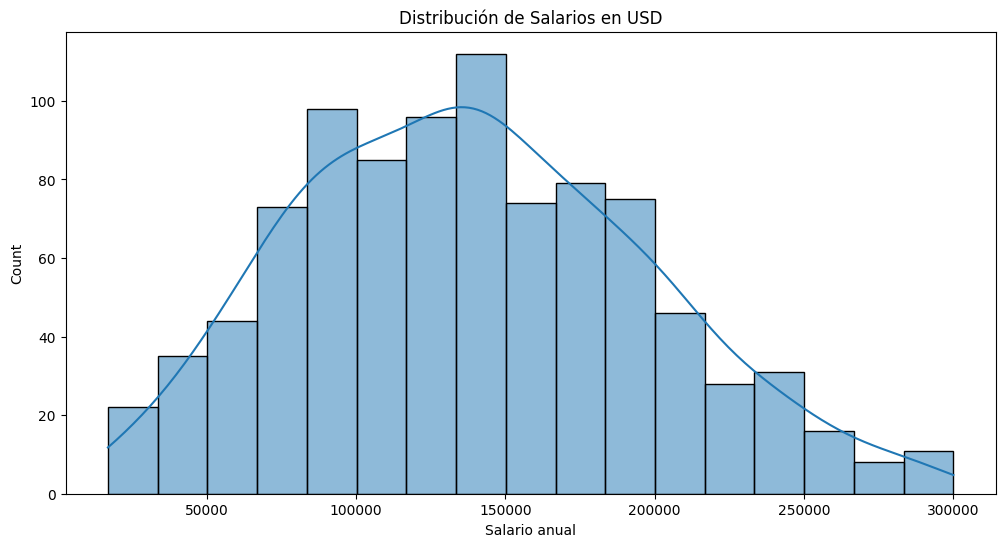

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a Pandas para visualización
pdf = df_transformed.sample(0.1).toPandas()

# Gráfico 1: Distribución salarial
plt.figure(figsize=(12, 6))
sns.histplot(pdf["salary_in_usd"], kde=True)
plt.title("Distribución de Salarios en USD")
plt.xlabel("Salario anual")
plt.show()



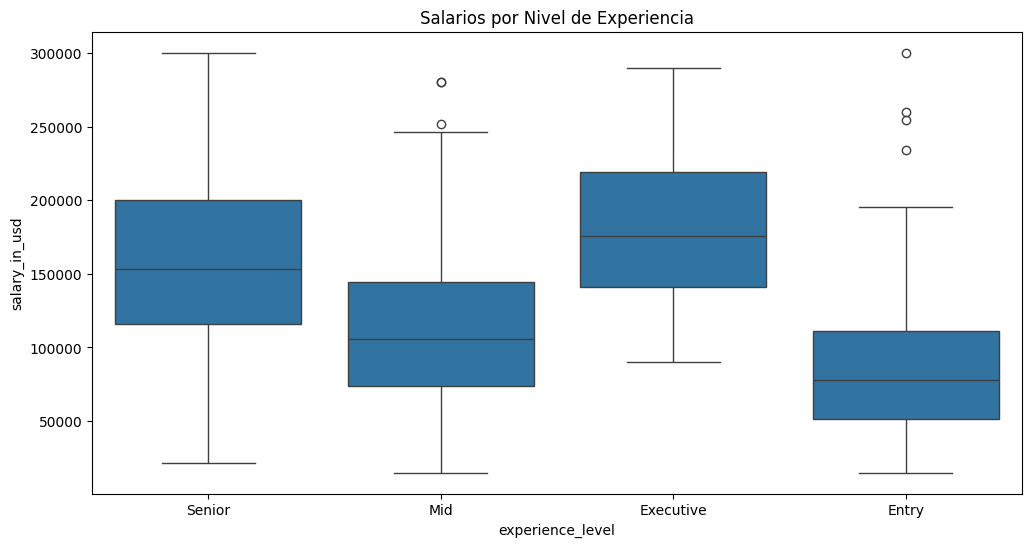

In [ ]:
# Gráfico 2: Salario por experiencia
plt.figure(figsize=(12, 6))
sns.boxplot(x="experience_level", y="salary_in_usd", data=pdf)
plt.title("Salarios por Nivel de Experiencia")
plt.show()

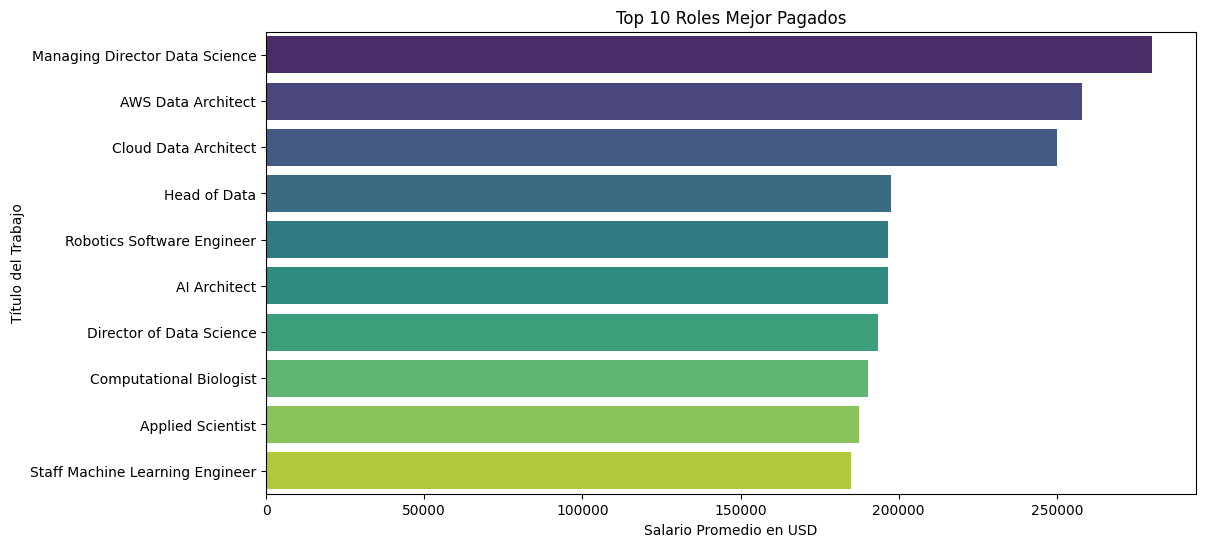

In [ ]:
# Top 10 roles mejor pagados
top_10_roles = df_transformed.groupBy("job_title") \
    .agg(avg("salary_in_usd").alias("avg_salary")) \
    .orderBy(col("avg_salary").desc()) \
    .limit(10) \
    .toPandas() # Convertir a Pandas DataFrame

# Visualización con Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_salary", y="job_title", data=top_10_roles, palette="viridis", hue="job_title", legend=False)
plt.title("Top 10 Roles Mejor Pagados")
plt.xlabel("Salario Promedio en USD")
plt.ylabel("Título del Trabajo")
plt.show()

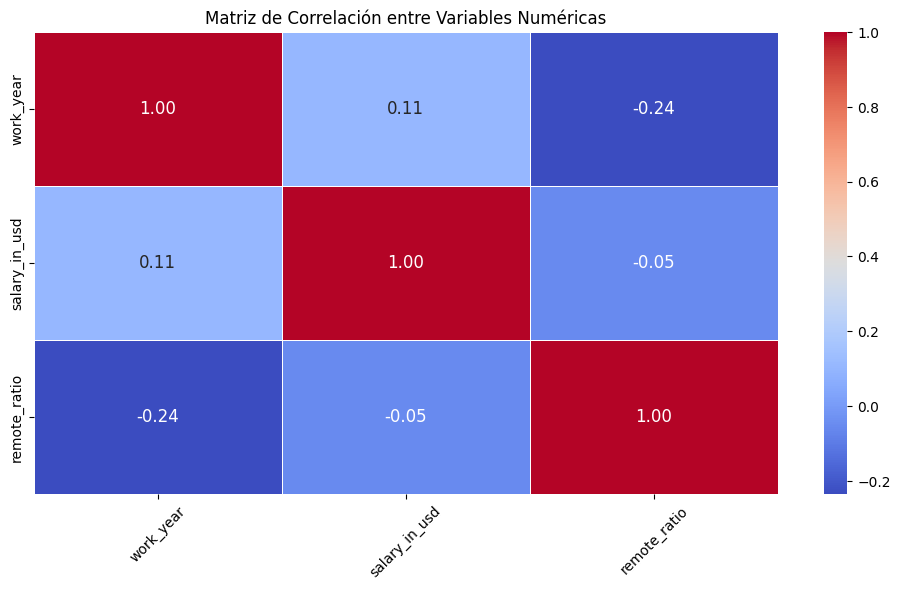

In [ ]:
# Convertir a Pandas para facilitar el cálculo de correlaciones
corr_pdf = df_transformed.select(
    "work_year",
    "salary_in_usd",
    "remote_ratio"
).toPandas()

# Calcular matriz de correlación
corr_matrix = corr_pdf.corr()

# Generar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 12}
)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Instalar librería para manejo de códigos de países
!pip install pycountry

import pycountry
from pyspark.sql.functions import upper

def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return "Desconocido"

# 1. Limpiar y mapear códigos de país
df_geo = df_transformed.withColumn("company_location", upper(col("company_location"))).filter(col("company_location") != "")

# 2. Agregar datos por país
country_stats = df_geo.groupBy("company_location") \
    .agg(
        count("*").alias("total_empleos"),
        avg("salary_in_usd").alias("salario_promedio")
    ).toPandas()

# 3. Mapear códigos a nombres de país
country_stats["country_name"] = country_stats["company_location"].apply(get_country_name)

# 4. Filtrar países desconocidos
country_stats = country_stats[country_stats["country_name"] != "Desconocido"]

## Visualizar con Plotly (mapa interactivo) Paises y sus salarios primedios.

In [ ]:
# 5. Visualizar con Plotly (mapa interactivo)
import plotly.express as px

fig = px.choropleth(
    country_stats,
    locations="country_name",  # Códigos ISO Alpha-2
    locationmode="country names",  # Especifica que usamos nombres de países
    color="salario_promedio",
    hover_data=["total_empleos", "salario_promedio"],
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Salario Promedio en USD por Ubicación de la Empresa",
    labels={"salario_promedio": "Salario Promedio (USD)"},
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
fig.show()

## Detener Spark

In [ ]:
# Finalizar sesión Spark
spark.stop()
print("Proceso completado exitosamente!")